<a href="https://colab.research.google.com/github/BLOOMFLARK/NN_noise_classification/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install colour-demosaicing

     |████████████████████████████████| 3.3MB 2.7MB/s 
     |████████████████████████████████| 1.6MB 27.7MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import os

from pathlib import Path


import numpy as np
import torchvision
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models, datasets

from albumentations import Compose, ToGray, Normalize, RandomCrop, Resize
#from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import random
print(os.listdir())

['.config', 'drive', 'sample_data']


In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

net = None

In [0]:
data_root = 'drive/My Drive/dl_noise_classification/data_tl/'
train_dir = 'train'
val_dir = 'val'
class_names = ['awgn', 'bayer']

train_dir = os.path.join(data_root, train_dir)
val_dir = os.path.join(data_root, val_dir)

In [0]:
batch_size = 50
lr = 1e-4
num_epochs = 100

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_dir, val_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

print("TRAIN_SIZE: {}\n VAL_SIZE: {}\n".format(train_size, val_size))

TRAIN_SIZE: 1200
 VAL_SIZE: 400



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


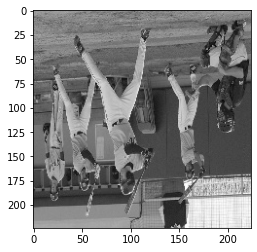

In [9]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [11]:
y_batch

tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1])

In [0]:
val_loss = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)

val_acc = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)


def train_model(model, loss, optimizer, scheduler, num_epochs):

    for epoch in range(num_epochs):

        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # training mode
                history_acc = train_acc
                history_loss = train_loss
            else:
                dataloader = val_dataloader
                model.eval()   # evaluate mode (dropout + bn)
                history_acc = val_acc
                history_loss = val_loss

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                #print(inputs, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase=='train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.cpu().item()
                running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            history_acc[epoch] = epoch_acc
            history_loss[epoch] = epoch_loss


            print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc), flush=True)

## Обучение сети VGG16 с последним линейным слоем

In [13]:
resnet = models.resnet152(pretrained=True)
#vgg = models.vgg16(pretrained=True)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [11]:
list(vgg.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [0]:
num_features = vgg.classifier[6].in_features
features = list(vgg.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(num_features, 2)]) # Add our layer with 2 outputs
vgg.classifier = torch.nn.Sequential(*features)

In [0]:
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 2)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet = resnet.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

# Decay LR by a factor of 0.5 every 20 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#    optimizer,
#    T_0=num_epochs//2,
#    eta_min=1e-10)

train_model(resnet, loss, optimizer, scheduler, num_epochs=num_epochs)

cuda:0
Epoch 0/99:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1240 Acc: 0.9558

val Loss: 0.2097 Acc: 0.9250

Epoch 1/99:
train Loss: 0.0731 Acc: 0.9767

val Loss: 0.3053 Acc: 0.9075

Epoch 2/99:
train Loss: 0.0447 Acc: 0.9833

val Loss: 0.1280 Acc: 0.9350

Epoch 3/99:
train Loss: 0.0395 Acc: 0.9858

val Loss: 0.4551 Acc: 0.9050

Epoch 4/99:
train Loss: 0.0441 Acc: 0.9817

val Loss: 0.2450 Acc: 0.8975

Epoch 5/99:
train Loss: 0.0446 Acc: 0.9858

val Loss: 0.5676 Acc: 0.8375

Epoch 6/99:
train Loss: 0.0428 Acc: 0.9833

val Loss: 0.2963 Acc: 0.9150

Epoch 7/99:
train Loss: 0.0228 Acc: 0.9925

val Loss: 0.4199 Acc: 0.8825

Epoch 8/99:
train Loss: 0.0379 Acc: 0.9858

val Loss: 0.2464 Acc: 0.9125

Epoch 9/99:
train Loss: 0.0243 Acc: 0.9908

val Loss: 1.1577 Acc: 0.7400

Epoch 10/99:
train Loss: 0.0331 Acc: 0.9883

val Loss: 0.1859 Acc: 0.9400

Epoch 11/99:
train Loss: 0.0119 Acc: 0.9958

val Loss: 0.0534 Acc: 0.9700

Epoch 12/99:
train Loss: 0.0296 Acc: 0.9883

val Loss: 0.2567 Acc: 0.9225

Epoch 13/99:
train Loss: 0.0345 Acc: 0.9892

va

KeyboardInterrupt: ignored

## PLOT Train and Val loss

In [0]:
train_loss = train_loss[train_loss > 0]
tl_shape = train_loss.shape[0]

train_acc = train_acc[train_acc > 0]
tc_shape = train_acc.shape[0]

In [27]:
train_loss.shape

(100,)

In [0]:
val_loss = val_loss[val_loss > 0]
val_acc = val_acc[val_acc > 0]

Text(0.5, 1.0, 'loss')

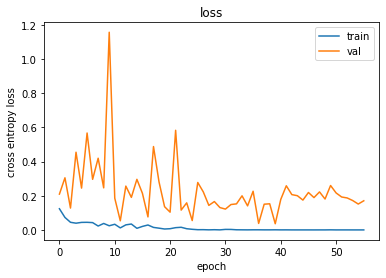

In [20]:
# Loss
plt.plot(range(56), train_loss[:56], val_loss[:56])
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')


Text(0.5, 1.0, 'accuracy')

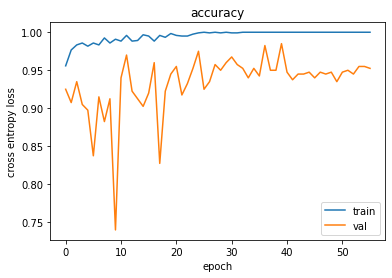

In [21]:
# accuracy
plt.plot(range(56), train_acc[:56], val_acc[:56])
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('accuracy')


In [0]:
$

## Тестовая выборка и data loader

In [0]:
test_paths = im_paths[20:30]
test_dataset = ImageDataset(test_paths, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=True, num_workers=0)

## Загрузка обученной модели

In [0]:
params_dict = torch.load('drive/My Drive/dl_noise_classification/20_train_500_epochs_vgg_best_val')
#model = models.resnet152(pretrained=False)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(params_dict)
model.eval()

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(num_features, 2)]) # Add our layer with 2 outputs
model.classifier = torch.nn.Sequential(*features)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [0]:
from tqdm import tqdm

test_predictions = []
test_img_sigmas = []
test_true = []
for inputs, labels, sigmas in tqdm(test_dataloader):
    test_true.append(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_sigmas.extend(sigmas)
    
y_pred = np.concatenate(test_predictions)
y_true = np.concatenate(test_true)

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [0]:
print(y_pred)

[ 0.5103151  0.5103151  0.5103151  0.5103151  0.5103151  0.5103151
  0.5103151  0.5103151  0.5103151  0.5103151]


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## ROC Curve

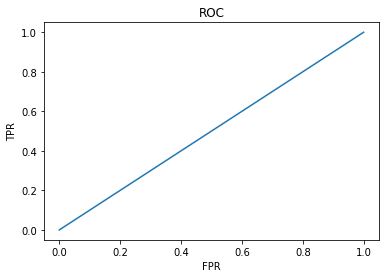

In [0]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr)

In [0]:
thresholds

array([ 1.5103152,  0.5103151], dtype=float32)

In [0]:
y_true

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0])

In [0]:
print("AUC: {}".format(roc_auc_score(y_true, y_pred)))


AUC: 0.5


## Точность в зависимости от порога

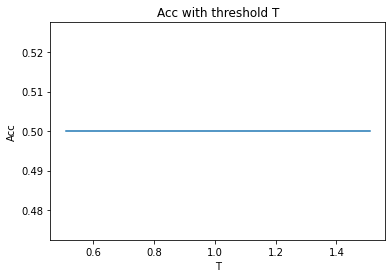

In [0]:
acc_history = []
t_history = []
for thresh in thresholds:
    y_hat = np.copy(y_pred)
    y_hat[y_hat > thresh] = 1
    y_hat[y_hat <= thresh] = 0
    accuracy = accuracy_score(y_true, y_hat)

    t_history.append(thresh)
    acc_history.append(accuracy)
    #print("Accuracy: {}, with threshold: {}".format(accuracy, thresh))

plt.title('Acc with threshold T')
plt.xlabel('T')
plt.ylabel('Acc')
plt.plot(t_history, acc_history)


array([ 0.47227594,  0.9996625 ,  0.5525067 ,  0.5744043 ,  0.5718775 ,
        0.60436624,  0.23836468,  0.659989  ,  0.5298564 ,  0.13553543,
        0.36954176,  0.5124735 ,  0.52312505,  0.52708185,  0.5880793 ,
        0.45013088,  0.56109136,  0.57235265,  0.5711936 ,  0.12979674,
        0.5353847 ,  0.6422717 ,  0.5695753 ,  0.59789217,  0.31670642,
        0.54615486,  0.47783807,  0.03903731,  0.5645977 ,  0.5616492 ], dtype=float32)